In [1]:
import keras
from keras import layers
from keras import backend as k
from keras.models import Model
import numpy as np
k.clear_session()

c:\users\brad\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2 #latent space shape is a 2-d plane corresponding to 2 node hidden layer values

In [3]:
input_img = keras.Input(shape = img_shape)
x = layers.Conv2D(32,3, padding = 'same', activation = 'relu')(input_img)
x = layers.Conv2D(64,3, padding = 'same', activation = 'relu', strides = (2,2))(x)
x = layers.Conv2D(64,3, padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(64,3, padding = 'same', activation = 'relu')(x)
shape_before_flattening = k.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)  #learn a 2 length vector for each node 
z_mean = layers.Dense(latent_dim, name = "z_meann")(x)
z_log_var = layers.Dense(latent_dim, name = "z_log_varn")(x)

In [4]:
def sampling(args):
    print(args)
    z_mean, z_log_var = args
    epsilon = k.random_normal(shape = (k.shape(z_mean)[0], latent_dim), mean = 0., stddev = 1.)
    print(epsilon)
    return z_mean + k.exp(z_log_var) * epsilon

In [5]:
z = layers.Lambda(sampling)([z_mean, z_log_var])
print(z)

[<tf.Tensor 'z_meann/BiasAdd:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'z_log_varn/BiasAdd:0' shape=(?, 2) dtype=float32>]
Tensor("lambda_1/random_normal:0", shape=(?, 2), dtype=float32)
[<tf.Tensor 'lambda_1/Placeholder:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'lambda_1/Placeholder_1:0' shape=(?, 2) dtype=float32>]
Tensor("lambda_1/random_normal_1:0", shape=(?, 2), dtype=float32)
Tensor("lambda_1/add:0", shape=(?, 2), dtype=float32)


In [6]:
decoder_input = layers.Input(k.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation = 'relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32,3,padding = 'same', activation = 'relu', strides = (2,2))(x)
x = layers.Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(x)
print(x)

Tensor("conv2d_5/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)


In [7]:
decoder = Model(decoder_input, x)
z_decoded = decoder(z)
print(z_decoded)

Tensor("model_1/conv2d_5/Sigmoid:0", shape=(?, ?, ?, 1), dtype=float32)


In [8]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        print(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * k.mean(1 + z_log_var - k.square(z_mean) - k.exp(z_log_var), axis = -1)
        return(k.mean(xent_loss + kl_loss)) #loss is average of classification error and the kullback liebler divergence
    
    def call(self, inputs):  # custom layer call override
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs = inputs)
        return x        

In [9]:
y = CustomVariationalLayer()([input_img, z_decoded])

Tensor("custom_variational_layer_1/Reshape_1:0", shape=(?,), dtype=float32)


In [10]:
from keras.datasets import mnist

In [11]:
vae = Model(input_img, y)
vae. compile(optimizer = 'rmsprop', loss = None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

c:\users\brad\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  


In [12]:
(x_train, _), (x_test, y_test) = mnist.load_data()

In [13]:
x_train = x_train.astype('float32')/255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32')/255.
x_test = x_test.reshape(x_test.shape + (1,))

In [46]:
vae.fit(x = x_train, y = None, shuffle = True, epochs = 25, batch_size = batch_size, validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 24s 399us/step - loss: 0.1911 - val_loss: 0.1897
Epoch 2/25
60000/60000 [==============================] - 24s 398us/step - loss: 0.1882 - val_loss: 0.1876
Epoch 3/25
60000/60000 [==============================] - 24s 403us/step - loss: 0.1865 - val_loss: 0.1872
Epoch 4/25
60000/60000 [==============================] - 24s 401us/step - loss: 0.1851 - val_loss: 0.1870
Epoch 5/25
60000/60000 [==============================] - 24s 405us/step - loss: 0.1841 - val_loss: 0.1841
Epoch 6/25
60000/60000 [==============================] - 24s 402us/step - loss: 0.1832 - val_loss: 0.1831
Epoch 7/25
60000/60000 [==============================] - 24s 403us/step - loss: 0.1824 - val_loss: 0.1863
Epoch 8/25
60000/60000 [==============================] - 24s 403us/step - loss: 0.1819 - val_loss: 0.1826
Epoch 9/25
60000/60000 [==============================] - 24s 404us/step - loss: 0.1814 - val_

In [18]:
config = vae.get_config()
#config

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 28, 28, 1),
    'dtype': 'float32',
    'name': 'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'filters': 32,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'conv2d_1',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'conv2d_1'},
 

In [19]:
vae.layers

In [20]:
#z_mean and z_log layer weights
print(vae.layers[8])
print(vae.layers[8].get_weights()[1])
print(vae.layers[7].get_weights()[1])

[-0.5313955  -0.40934536]
[-0.07539756  0.02432451]


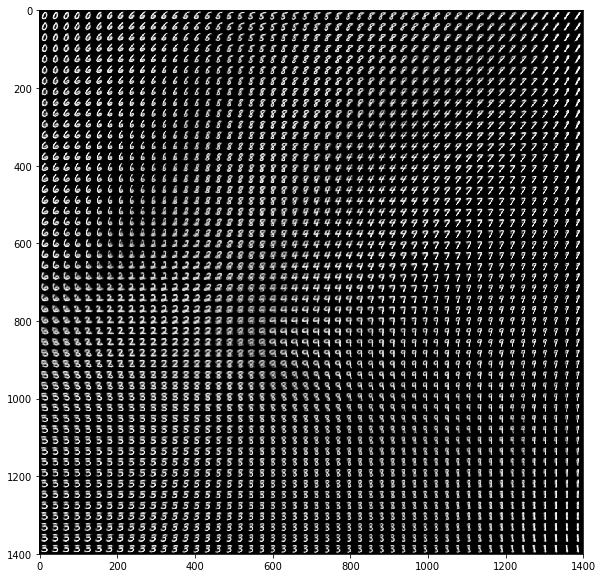

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import norm

#fig, ax = plt.subplots(1, 1)
#mean, var, skew, kurt = norm.stats(moments='mvsk')
#x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
#ax.plot(x, norm.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')

n = 50
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(.05,.95, n))
grid_y = norm.ppf(np.linspace(.05,.95, n))

#print(grid_x, grid_y)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #print(z_sample)
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        #print(z_sample)
        x_decoded = decoder.predict(z_sample, batch_size = batch_size)
        #print(x_decoded)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i+1)*digit_size,
              j * digit_size: (j+1)*digit_size] = digit
plt.figure(figsize = (10,10))
plt.imshow(figure, cmap = "Greys_r")
plt.show()

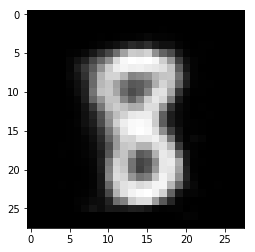

In [48]:
plt.imshow(decoder.predict(np.tile([[.01,.8]],batch_size).reshape(batch_size,2))[0].reshape(28,28),cmap="Greys_r")